In [1]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import cv2
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader

WORK_DIR = Path(Path.cwd()).parent
sys.path.append(str(WORK_DIR))
from src.datasets import get_dataset, get_dataloader
from src.utils import parse_data_cfg, IMG, FPHA, LMDB, DATA_DIR

In [2]:
exp_folder = 'exp4'
cfgname = 'fpha_hpo_action_noun_base'
cfg = parse_data_cfg(WORK_DIR/'data_cfg'/exp_folder/(cfgname + '.cfg'))
epoch = 200
exp_dir = cfg["exp_dir"]
data_split = 'test'
split_set = cfg[data_split + '_set']

In [3]:
action_dict = {}
noun_dict = []
with open(Path(DATA_DIR)/'First_Person_Action_Benchmark/action_object_info.txt', 'r') as f:
        lines = f.readlines()[1:]
        for l in lines:
            l = l.split(' ')
            noun_dict.append(l[2])
            action_dict[int(l[0]) - 1] = l[1]
noun_dict = np.unique(noun_dict)
noun_dict = {v: k for v, k in enumerate(noun_dict)}

# Visualize Dataloader

In [ ]:
dataset_kwargs = {'split_set': split_set}
dataset   = get_dataset(cfg, dataset_kwargs)
sampler   = None
shuffle   = cfg['shuffle']
kwargs = {'batch_size'  :   int(cfg['batch_size']),
          'shuffle'     :   shuffle,
          'num_workers' :   int(cfg['num_workers']),
          'pin_memory'  :   True}
data_loader = get_dataloader(dataset, sampler, kwargs)

In [ ]:
idx = 0 
for i, (img, uvd_gt) in enumerate(data_loader):
    if i == idx:
        batch_size = img.shape[0]
        img = img.cpu().numpy()
        img = np.swapaxes(img, 2, 3)
        img = np.swapaxes(img, 1, 3)
        img = IMG.scale_img_255(img)
        uvd_gt = uvd_gt.cpu().numpy()
        uvd_gt = np.squeeze(uvd_gt)
        break
    i += 1

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
idx = 0
for i in range(4):
    for j in range(4):
        k = np.ravel_multi_index((i, j), (4, 4))
        if k >= len(img):
            break        
        cur_img = img[idx]
        u = uvd_gt[idx]        
        ax[i, j].imshow(cur_img)
        u = IMG.scale_points_WH(u, (1,1), (cur_img.shape[0], cur_img.shape[1]))
        FPHA.visualize_joints_2d(ax[i, j], u[FPHA.REORDER_IDX], joint_idxs=False)
        idx += 1

# Evaluation

In [4]:
root = Path(DATA_DIR)/'First_Person_Action_Benchmark'
with open(root/(split_set + '_img.txt'), 'r') as f:
    img_labels = f.read().splitlines()
img_path   = [i.split(' ')[0] for i in img_labels]
action_id  = [int(i.split(' ')[1]) for i in img_labels]
noun_id    = [int(i.split(' ')[2]) for i in img_labels]

xyz_gt = np.loadtxt(root/(split_set + '_xyz.txt'))
xyz_gt = np.reshape(xyz_gt, (-1, 21, 3))
uvd_gt = FPHA.xyz2uvd_color(xyz_gt)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_best.txt'.format(epoch, data_split))
pred_uvd = np.reshape(np.loadtxt(pred_file), (-1, 21, 3))
pred_uvd = IMG.scale_points_WH(pred_uvd, (1, 1), (1920, 1080))
pred_uvd[..., 2] *= 1000
pred_xyz = FPHA.uvd2xyz_color(pred_uvd)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_conf.txt'.format(epoch, data_split))
pred_conf = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_top5_action.txt'.format(epoch, data_split))
pred_top5_action = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_top5_noun.txt'.format(epoch, data_split))
pred_top5_noun = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_action_dist.txt'.format(epoch, data_split))
pred_action_dist = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_noun_dist.txt'.format(epoch, data_split))
pred_noun_dist = np.loadtxt(pred_file)


# Hand

Subject_1/sprinkle/1/color/color_0093.jpeg
GT action: sprinkle
GT noun: spoon
Predicted action: sprinkle
Predicted noun: spoon


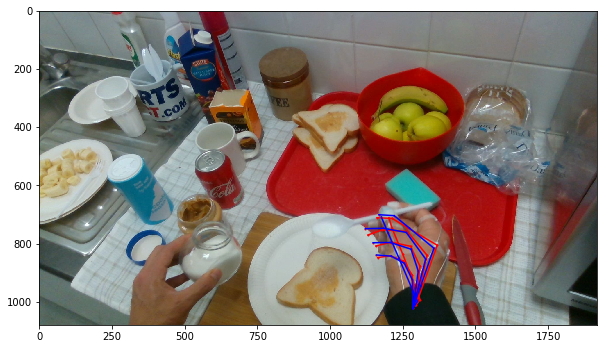

In [5]:
idx = 1000
print(img_path[idx])
print('GT action:', action_dict[action_id[idx]])
print('GT noun:', noun_dict[noun_id[idx]])
print('Predicted action:', action_dict[pred_top5_action[int(idx)][0]])
print('Predicted noun:', noun_dict[pred_top5_noun[int(idx)][0]])
img = np.asarray(Image.open(os.path.join(DATA_DIR, 'First_Person_Action_Benchmark', 'Video_files', img_path[idx])))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

FPHA.visualize_joints_2d(ax, pred_uvd[idx][FPHA.REORDER_IDX], joint_idxs=False, c='r')
FPHA.visualize_joints_2d(ax, uvd_gt[idx][FPHA.REORDER_IDX], joint_idxs=False, c='b')

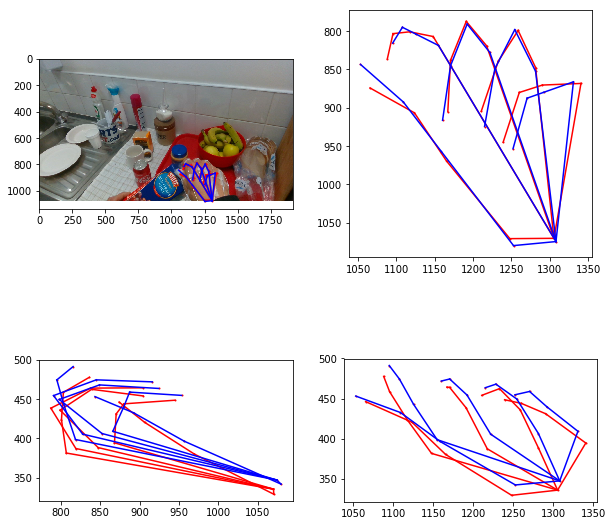

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221)
ax.imshow(img)
FPHA.visualize_joints_2d(ax, pred_uvd[idx][FPHA.REORDER_IDX], joint_idxs=False, c='r')
FPHA.visualize_joints_2d(ax, uvd_gt[idx][FPHA.REORDER_IDX], joint_idxs=False, c='b')

for proj_idx, (proj_1, proj_2) in enumerate([[0, 1], [1, 2], [0, 2]]):
    ax = fig.add_subplot(2, 2, 2 + proj_idx)
    if proj_idx == 0:
        # Invert y axes to align with image in camera projection
        ax.invert_yaxis()
    ax.set_aspect('equal')
    FPHA.visualize_joints_2d(ax,
                        np.stack(
                            [pred_uvd[idx][FPHA.REORDER_IDX][:, proj_1], 
                             pred_uvd[idx][FPHA.REORDER_IDX][:, proj_2]],
                            axis=1),
                        joint_idxs=False, c='r')
    FPHA.visualize_joints_2d(ax,
                        np.stack(
                            [uvd_gt[idx][FPHA.REORDER_IDX][:, proj_1], 
                             uvd_gt[idx][FPHA.REORDER_IDX][:, proj_2]],
                            axis=1),
                        joint_idxs=False, c='b')    

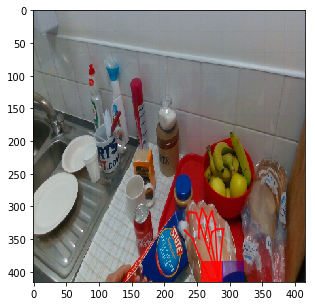

In [9]:
max_idx = []
# get the best idx for each 2D cell
for i in range(len(pred_conf[idx])//5):
    max_idx.append(i*5 + np.argmax(pred_conf[idx][i*5:i*5+5]))

fig, ax = plt.subplots(figsize=(5,5))
pred_uvd_416 = IMG.scale_points_WH(pred_uvd[idx], (1920, 1080), (416, 416))
uvd_gt_416 = IMG.scale_points_WH(uvd_gt[idx], (1920, 1080), (416, 416))
FPHA.visualize_joints_2d(ax, pred_uvd_416[FPHA.REORDER_IDX], joint_idxs=False, c='r')
# FPHA.visualize_joints_2d(ax, uvd_gt_416[FPHA.REORDER_IDX], joint_idxs=False, c='b')
img_rsz = IMG.resize_img(img, (416, 416))
ax.imshow(img_rsz.astype('uint32'))

# red is the best
# yellow is anything over 0.9
import matplotlib.patches as patches
for i in range(len(max_idx)):
    index = np.unravel_index(i, (13, 13))
    x = index[1]
    y = index[0]
    al = pred_conf[idx][max_idx[i]]
    if al == np.amax(pred_conf[idx]):
        c = 'r'
    elif al <= 0.8:
        c = 'b'
    else:
        c = 'y'
    rect = patches.Rectangle((x*32,y*32),32,32,linewidth=1, edgecolor=c, facecolor=c, fill=True, alpha=al)
    ax.add_patch(rect)

In [10]:
print('%s UVD mean_l2_error: ' %data_split, FPHA.mean_L2_error(uvd_gt[:len(pred_uvd)], pred_uvd))
print('%s XYZ mean_l2_error: ' %data_split, FPHA.mean_L2_error(xyz_gt[:len(pred_uvd)], pred_xyz))
error = []
for i, (pred, uvd) in enumerate(zip(pred_uvd, uvd_gt)):
#     print(i, FPHA.mean_L2_error(uvd, pred))
    error.append(FPHA.mean_L2_error(uvd, pred))
error = np.asarray(error)
min_error_idx = np.argmin(error)
max_error_idx = np.argmax(error)
print('Best Pose id:', min_error_idx, 'uvd_error:', error[min_error_idx])
print('Worst Pose id:', max_error_idx, 'uvd_error:', error[max_error_idx])
for idx in np.argsort(error):
    print(idx)

test UVD mean_l2_error:  33.55486918884422
test XYZ mean_l2_error:  19.82386640725387
Best Pose id: 27903 uvd_error: 5.5877087807560955
Worst Pose id: 16043 uvd_error: 212.56108476716756
27903
28640
11335
27904
10113
7261
8398
14093
8386
1412
8374
27470
14043
1411
1413
14070
10125
27901
34395
14052
10152
34363
28639
11336
19278
27902
10143
14023
10139
1142
20520
10096
10117
20504
20513
27430
10169
18286
10095
27910
26644
26640
10166
10157
14015
14086
35229
34393
1414
26658
27908
10133
26636
1144
10076
10107
10168
1410
14022
7259
19279
10132
4031
10151
1408
2208
8389
11354
14081
34374
14027
18285
10119
14016
26344
19164
31375
27905
27909
27899
8399
456
26659
34396
34392
14035
27906
27475
8387
14044
14048
27476
11355
14080
14053
10129
11318
451
10094
18627
10137
27900
26657
1393
10142
19253
14051
10153
20521
11332
1409
19165
14056
7260
27898
26645
34375
8396
10104
34383
4035
19305
33900
8400
1074
34369
27907
10088
10112
4033
8102
34364
34384
10130
34401
19254
14059
34370
14045
26629
1015

32446
4163
18607
19130
26204
11950
30299
8341
33033
30229
30936
1575
37414
26705
18184
1745
20858
27427
8361
11679
26182
40370
4210
20939
5810
1078
10206
30799
32304
9278
37478
18959
8342
7809
20196
1791
1585
32880
26462
9232
20930
22553
8146
32708
2337
11567
18353
998
39747
23216
2508
12976
33039
31282
3315
2810
10262
26549
26215
32957
37002
38292
7900
31392
33830
40429
19110
2439
33759
18299
8364
20824
32742
11607
1970
37627
13349
2706
38747
10468
11972
19090
18458
19405
8042
13355
31543
32241
20539
33073
24589
1178
18858
14063
2141
39917
32034
1438
33851
20106
31121
18930
11359
37433
33550
19041
2028
11566
10544
39726
19643
31041
19409
11638
4230
12245
20780
26459
10013
30993
33034
979
26394
11778
33309
2082
1339
2513
5803
353
44631
40125
2342
32623
2358
10985
11443
31690
36657
4236
4165
25669
32488
40608
10269
8347
27364
18355
9297
32392
4249
31972
19196
26216
33847
8365
20114
2022
27488
23201
3203
19051
19048
299
2017
32864
3316
4530
19927
27682
1013
20431
18456
19201
82
23209
778

19802
21807
32790
30471
4452
27483
31544
5751
11994
24582
4723
25388
1889
625
32104
16351
40127
37740
4588
9294
32713
31113
11969
4134
321
15527
11328
18398
32969
19018
32967
26680
31419
19402
37809
12168
4589
32805
18329
25863
30311
22679
318
10335
9795
2127
31029
2368
30942
7747
32178
13368
4008
7831
12030
18549
20026
32501
29967
38311
1284
26997
37623
39790
5826
38153
5761
4584
23159
30811
5765
24583
42780
3728
39913
37039
31079
618
594
5757
20406
24009
21410
26545
26481
26437
37276
37637
23154
9516
39931
19216
13
662
8129
32260
37344
31781
3694
13072
24011
19932
286
2812
33666
31243
20833
18453
21039
15383
9718
13372
3253
34024
31242
4538
9738
4794
39989
588
18922
11115
5845
32676
1288
31932
9925
18603
20258
9364
1313
18595
32963
2567
32639
38376
27656
19550
9839
22652
12227
19195
2783
7940
31532
39
32758
3706
3873
1346
1743
31705
7814
33588
39993
11704
1809
23138
31779
746
30282
26771
910
33745
30246
5779
19400
1279
32568
293
32279
15394
1248
8563
22647
2503
31766
30215
20179
1364

11027
12932
198
20450
29867
38156
20343
440
24305
14304
34018
10185
32586
31424
39826
21458
36858
40462
39868
40612
26852
26284
26782
3018
3657
33875
22906
22135
26056
21093
33686
24192
7758
1129
32173
18327
24480
238
39986
33887
22603
12940
15415
19489
10235
1870
37925
38307
9090
44080
23127
27284
7081
13011
2395
11475
9369
25971
3724
32589
146
9404
218
19192
32096
31870
19450
10584
19392
40575
36595
41157
21882
980
7213
31962
20337
9891
32698
37295
4013
30058
333
11437
4205
40364
9400
39610
38377
11952
27772
24481
40461
27256
15377
24376
39616
20971
7792
14943
1951
9662
24302
2903
31464
41195
30909
22578
4803
9476
30213
19349
31736
20267
31064
20309
9345
6939
19447
32328
8919
25087
32801
40104
20189
39778
23961
4816
185
24398
37056
5294
25766
25941
5253
653
5882
40615
31869
38550
7817
21283
27005
12163
3672
27520
21775
31097
25940
2116
11522
27547
23123
20574
37099
30835
12160
40481
21001
2939
30671
408
37707
37486
44577
40682
221
40715
22626
679
25714
31606
20897
24028
18581
9613
79

12636
13973
9124
6240
18948
31294
27942
27742
24397
12919
15413
29442
3283
11863
9388
21120
17446
31184
23379
9911
13497
14348
10549
34142
31226
19985
209
32159
27706
6238
23999
37317
20655
39412
22941
22170
6987
7647
211
22744
9961
2720
2672
27223
30860
20363
341
5429
31386
12324
5302
24382
24310
23339
14630
5305
26173
9676
33408
4482
1525
31309
33602
13868
3818
31958
26487
16340
10550
37360
14871
4464
11493
39202
3786
40570
33880
40140
38543
5388
12639
33809
11690
13595
8558
23061
25084
23060
20487
40494
11915
27660
11521
21076
10387
41214
23944
20444
13078
36542
2531
5376
837
6701
3829
27671
3338
32714
12789
14438
31523
11940
3070
531
31957
31547
3288
12538
25277
32518
25588
21558
40787
18402
39971
21309
18917
40087
8871
34482
41203
26593
392
13775
22447
7619
17596
29630
37028
5704
5226
22205
22976
21187
25171
30055
17593
22454
13276
26913
16141
37114
26248
5251
9570
26091
24014
2093
37746
27318
13065
26488
31111
17853
20214
19989
5419
22947
22176
20278
27755
42764
44657
27727
11229

21324
30362
25610
20380
37023
8870
25502
6062
9870
38816
2698
5435
37451
31203
2266
22465
37659
12906
13384
9088
9575
2913
38903
19794
30510
30604
2607
22228
43437
30885
39431
34481
16392
3820
13875
7609
14885
13866
3307
38159
4765
39195
12796
23750
44232
9177
4345
30555
37184
30889
24371
26105
13278
116
20383
10609
40742
35728
18676
18009
20543
28209
35710
14408
5490
19790
34478
21062
9157
25753
13062
12695
11909
13139
72
33787
23031
11799
10382
33201
22509
18911
14769
3182
12046
6061
33445
3892
21707
21061
33444
34510
26885
9181
29169
5633
33910
30893
2668
24058
230
27155
21844
35170
25874
27662
24100
38006
6951
26929
20080
5798
12783
17418
371
38631
37701
21902
5363
23759
10647
29566
11263
37922
13098
20979
33727
11872
2638
14429
3356
20350
11431
39836
39447
39602
39460
8917
40560
26316
15189
25594
13223
39230
34073
22275
20748
27892
43959
12775
38479
4260
24068
39462
24289
37840
14924
5238
21146
17434
25182
8918
8690
11914
23337
37910
3362
3191
14273
13234
5492
27666
17280
38496
28

36483
13421
14952
35102
32891
39494
31631
12580
30924
17813
24402
34101
33865
12737
3490
10889
37075
32141
15899
34410
7043
172
7581
40984
11927
20637
3124
40514
35273
27845
10916
5961
8537
38239
34132
30082
15285
25903
40283
39840
25732
15117
30575
2695
8183
12475
26979
25117
14734
6033
43429
43394
21168
2445
33245
25537
10680
25481
35892
21717
21680
33417
14360
17163
36641
37853
34485
43818
39265
24574
4125
41290
22000
28403
40561
37873
30197
4501
30467
16663
10735
27309
38247
28988
12903
31727
16935
20973
5685
2853
36619
8450
4406
15291
13016
15304
30087
38737
39442
5592
37678
35277
37889
29478
11928
35433
3479
12570
21593
14889
13717
13259
35681
9897
5960
42702
36726
16664
16678
27967
26939
22244
26130
43440
37764
22762
28281
43977
13940
33340
41446
6549
28480
24390
10894
4351
7414
14386
12534
22119
22890
21038
22483
16809
41287
19861
15753
8619
20623
10731
17421
5605
8914
29786
33724
15299
34520
44708
25902
3931
33246
35737
11184
7014
11908
27984
32310
24540
17840
34436
13283
2288

24917
8406
27962
13020
22784
5213
13745
23578
25069
23569
5138
22922
22151
38784
39528
34230
6537
34313
16033
4302
28609
13258
4287
38968
14596
33180
43179
4744
28467
34934
35540
13952
30190
28470
25239
14468
29406
43124
39880
15932
42815
23601
15096
17160
9458
16695
43133
27951
25573
29704
27565
14997
9009
16749
23627
29511
14471
30417
27276
22255
26508
22048
30608
43951
29683
36334
40555
39365
12840
28158
33355
8648
43334
25641
31617
25043
27278
19863
23561
29181
44726
38063
5691
43752
41264
27333
17624
25519
42515
41806
12890
39301
37241
12593
41502
16658
35690
34926
17002
39529
28124
23564
8668
25188
37901
27950
22008
3496
16041
14549
29670
7333
10891
27955
8416
25068
40979
42411
5172
22049
27568
43132
36781
30400
875
876
15584
6569
33510
23249
44109
30158
29163
34982
15225
35871
39372
24902
36776
24170
41398
14967
37224
17792
12894
22832
35921
33459
44155
11390
23562
13181
29894
41366
16934
13796
24916
22222
41292
11806
40187
29306
25184
34892
28495
16932
29777
32194
29164
31906
8

25155
35966
16576
42953
29050
17531
36167
14689
37916
40409
9049
17695
3530
4918
43772
15070
42811
27541
44319
28692
41842
20951
34598
27078
41570
16733
27038
24789
16255
15952
16268
5120
4696
29265
29062
16801
21346
41071
16192
25126
24997
28540
24169
3598
3546
32336
24858
42707
22023
21143
23362
29096
9225
7335
25463
23460
11221
28556
16419
41805
21732
14513
14129
41572
29713
25020
41890
23350
15088
43288
43086
14205
28340
17868
25028
23266
29129
28762
5085
28763
35453
23858
3623
39298
28524
39235
43205
2541
16939
6926
31747
29191
5089
33779
32934
16627
28844
37246
38069
29270
34875
12091
15832
4751
888
41751
43899
16305
41069
42867
19865
33919
25248
12500
29813
42236
16623
25018
21658
25203
7306
31594
11222
12381
36154
4699
39530
44809
16795
32895
8510
42966
13732
27037
16836
43047
40962
17869
35576
32930
3547
42652
3474
10964
17622
34803
44310
14335
23429
7418
18141
12082
6905
7416
29071
36779
43085
43534
6613
35746
28074
3568
25154
44740
14694
24635
42288
44455
21378
23353
13040
2

8494
33712
34263
24883
35352
3462
4391
6324
44101
34686
42166
29811
14839
17196
24893
44672
4895
28933
43546
42593
37250
35366
25273
42607
44792
28942
37568
41093
36274
24980
7606
8461
35530
27526
36068
7209
6456
29731
34643
29927
35112
38339
43276
6931
6369
17120
20649
17898
35658
43251
24801
24802
43068
34276
7295
5022
42185
35801
14166
23326
43729
24803
35512
24832
28056
4913
7129
7181
16847
35361
6478
36072
14980
41688
35337
16648
34286
6457
24825
29090
35485
17992
43064
28908
42013
7180
6268
29293
35414
41604
36187
13698
23874
6325
5047
29243
27177
34647
28419
24979
44209
8492
43066
38334
15329
38405
24957
23867
6653
43069
37249
42544
44144
7211
41095
4903
42401
43963
43721
6370
4338
44780
34939
8799
43071
24843
24977
43810
28321
4631
23295
6892
28704
17023
16846
16844
43893
44423
35522
43719
29781
42167
35638
35753
6386
6304
34265
34944
34945
35406
29240
17702
41610
35363
7208
42052
22126
22897
27528
42207
23287
17020
7156
17915
28815
125
42989
29032
7197
42336
28729
35367
39033


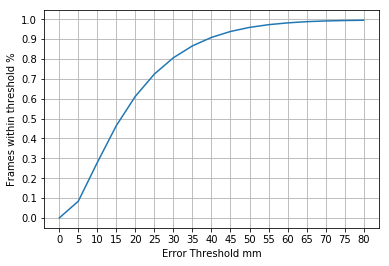

[0.0, 0.084127106, 0.27916664, 0.4649467, 0.6121547, 0.7241496, 0.8061905, 0.86588407, 0.9084669, 0.9383413, 0.9588267, 0.9724806, 0.98155314, 0.98767906, 0.99125135, 0.9934151, 0.9948268, ]
AUC: 0.7541279310826212


In [11]:
pck = FPHA.percentage_frames_within_error_curve(xyz_gt[:len(pred_uvd)], pred_xyz)
pck_str = '['
for p in pck:
    pck_str += str(p) + ', '
pck_str += ']'
print(pck_str)
thresholds = np.arange(0, 85, 5)
print('AUC:', FPHA.calc_auc(pck, thresholds))

# Action

In [12]:
top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
for pred, gt in zip(pred_top5_action, action_id):
    if gt not in top1_cls_acc:
        top1_cls_acc[gt] = 0
    if gt not in top5_cls_acc:
        top5_cls_acc[gt] = 0
    if gt not in total_gt:
        total_gt[gt] = 0

    if pred[0] == gt:
        top1_cls_acc[gt] += 1
    if gt in pred:
        top5_cls_acc[gt] += 1
    
    total_gt[gt] += 1
    
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 Per-frame mean-class ACTION accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 Per-frame mean-class ACTION accuracy:', np.mean(cls_mean)*100)

Top 1 Per-frame mean-class ACTION accuracy: 83.76961719360587
Top 5 Per-frame mean-class ACTION accuracy: 97.86792721418706


In [28]:
seq_dict = {}
gt_dict = {}
for path, pred, gt in zip(img_path, pred_action_dist, action_id):
    if path[:-10] not in seq_dict:
        seq_dict[path[:-10]] = []
    if path[:-10] not in gt_dict:
        gt_dict[path[:-10]] = gt 
    
    seq_dict[path[:-10]].append(pred)

top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
number_of_frames_per_sequence = 50
for k in seq_dict.keys():
    new_seq_dict = []
#     number_of_frames_per_sequence = len(seq_dict[k])
    new_range = np.linspace(0, len(seq_dict[k]) - 1, number_of_frames_per_sequence).astype('uint32')
    for i in new_range:
        new_seq_dict.append(seq_dict[k][i])
    avg_dist = np.mean(new_seq_dict, axis=0)
    top5_pred = avg_dist.argsort()[-5:][::-1]
    if gt_dict[k] not in top1_cls_acc:
        top1_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in top5_cls_acc:
        top5_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in total_gt:
        total_gt[gt_dict[k]] = 0
        
    if top5_pred[0] == gt_dict[k]:
        top1_cls_acc[gt_dict[k]] += 1
    if gt_dict[k] in top5_pred:
        top5_cls_acc[gt_dict[k]] += 1
        
    total_gt[gt_dict[k]] += 1
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 distribution consensus mean-class ACTION accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 distribution consensus mean-class ACTION accuracy:', np.mean(cls_mean)*100)

Top 1 distribution consensus mean-class ACTION accuracy: 88.4899289163995
Top 5 distribution consensus mean-class ACTION accuracy: 99.1111111111111


In [14]:
# TODO: Optimize this mess
cur_seq = img_path[0][:-10]
cur_gt = action_id[0]
top1_cls_acc = {}
total_gt = {}
seq_pred = []
for path, pred, gt in zip(img_path, pred_top5_action, action_id):
    if path[:-10] == cur_seq:
        seq_pred.append(pred[0])
    else:
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        

        # totalling
        total = len(seq_pred)
        pred_class = np.bincount(seq_pred)
        pred_class = np.argmax(pred_class)
        if pred_class == cur_gt:
            top1_cls_acc[cur_gt] += 1
        total_gt[cur_gt] += 1
        
        # init
        seq_pred = []
        seq_pred.append(pred[0])
        cur_gt = gt
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        
        
if cur_gt not in top1_cls_acc:
    top1_cls_acc[cur_gt] = 0
if cur_gt not in total_gt:
    total_gt[cur_gt] = 0        

# totalling
total = len(seq_pred)
pred_class = np.bincount(seq_pred)
pred_class = np.argmax(pred_class)
if pred_class == cur_gt:
    top1_cls_acc[cur_gt] += 1
total_gt[cur_gt] += 1

cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 video consensus mean-class ACTION accuracy:', np.mean(cls_mean)*100)

Top 1 video consensus mean-class ACTION accuracy: 83.82627377949541


# Noun

In [15]:
top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
for pred, gt in zip(pred_top5_noun, noun_id):
    if gt not in top1_cls_acc:
        top1_cls_acc[gt] = 0
    if gt not in top5_cls_acc:
        top5_cls_acc[gt] = 0
    if gt not in total_gt:
        total_gt[gt] = 0

    if pred[0] == gt:
        top1_cls_acc[gt] += 1
    if gt in pred:
        top5_cls_acc[gt] += 1
    
    total_gt[gt] += 1
    
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 Per-frame mean-class NOUN accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 Per-frame mean-class NOUN accuracy:', np.mean(cls_mean)*100)

Top 1 Per-frame mean-class NOUN accuracy: 86.00171480016124
Top 5 Per-frame mean-class NOUN accuracy: 98.57592541218581


In [19]:
seq_dict = {}
gt_dict = {}
for path, pred, gt in zip(img_path, pred_noun_dist, noun_id):
    if path[:-10] not in seq_dict:
        seq_dict[path[:-10]] = []
    if path[:-10] not in gt_dict:
        gt_dict[path[:-10]] = gt 
    
    seq_dict[path[:-10]].append(pred)

top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
number_of_frames_per_sequence = len(seq_dict)
for k in seq_dict.keys():
    new_seq_dict = []
    number_of_frames_per_sequence = len(seq_dict[k])
    new_range = np.linspace(0, len(seq_dict[k]) - 1, number_of_frames_per_sequence).astype('uint32')
    for i in new_range:
        new_seq_dict.append(seq_dict[k][i])
    avg_dist = np.mean(new_seq_dict, axis=0)
    top5_pred = avg_dist.argsort()[-5:][::-1]
    if gt_dict[k] not in top1_cls_acc:
        top1_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in top5_cls_acc:
        top5_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in total_gt:
        total_gt[gt_dict[k]] = 0
        
    if top5_pred[0] == gt_dict[k]:
        top1_cls_acc[gt_dict[k]] += 1
    if gt_dict[k] in top5_pred:
        top5_cls_acc[gt_dict[k]] += 1
        
    total_gt[gt_dict[k]] += 1
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 distribution consensus mean-class NOUN accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 distribution consensus mean-class NOUN accuracy:', np.mean(cls_mean)*100)

Top 1 distribution consensus mean-class NOUN accuracy: 88.74612920943432
Top 5 distribution consensus mean-class NOUN accuracy: 99.74358974358975


In [17]:
# TODO: Optimize this mess
cur_seq = img_path[0][:-10]
cur_gt = noun_id[0]
top1_cls_acc = {}
total_gt = {}
seq_pred = []
for path, pred, gt in zip(img_path, pred_top5_noun, noun_id):
    if path[:-10] == cur_seq:
        seq_pred.append(pred[0])
    else:
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        

        # totalling
        total = len(seq_pred)
        pred_class = np.bincount(seq_pred)
        pred_class = np.argmax(pred_class)
        if pred_class == cur_gt:
            top1_cls_acc[cur_gt] += 1
        total_gt[cur_gt] += 1
        
        # init
        seq_pred = []
        seq_pred.append(pred[0])
        cur_gt = gt
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        
        
if cur_gt not in top1_cls_acc:
    top1_cls_acc[cur_gt] = 0
if cur_gt not in total_gt:
    total_gt[cur_gt] = 0        

# totalling
total = len(seq_pred)
pred_class = np.bincount(seq_pred)
pred_class = np.argmax(pred_class)
if pred_class == cur_gt:
    top1_cls_acc[cur_gt] += 1
total_gt[cur_gt] += 1

cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 video consensus mean-class NOUN accuracy:', np.mean(cls_mean)*100)

Top 1 video consensus mean-class NOUN accuracy: 86.00117736206738


# Z-normalized

In [ ]:
z_norm_pred_xyz = []
for gt, pred in tqdm(zip(xyz_gt, pred_xyz)):
    new_pred = pred.copy()
    new_pred[:, 2] = new_pred[:, 2] - np.mean(pred[:, 2]) + np.mean(gt[:, 2])
    z_norm_pred_xyz.append(new_pred)

In [ ]:
print('%s XYZ mean_l2_error: ' %data_split, FPHA.mean_L2_error(xyz_gt, z_norm_pred_xyz))
z_norm_pred_uvd = FPHA.xyz2uvd_color(np.asarray(z_norm_pred_xyz))
print('%s UVD mean_l2_error: ' %data_split, FPHA.mean_L2_error(uvd_gt, z_norm_pred_uvd))
error = []
for i, (pred, uvd) in enumerate(zip(pred_uvd, uvd_gt)):
#     print(i, FPHA.mean_L2_error(uvd, pred))
    error.append(FPHA.mean_L2_error(uvd, pred))
error = np.asarray(error)
min_error_idx = np.argmin(error)
max_error_idx = np.argmax(error)
print('Best Pose id:', min_error_idx, 'uvd_error:', error[min_error_idx])
print('Worst Pose id:', max_error_idx, 'uvd_error:', error[max_error_idx])
for idx in np.argsort(error):
    print(idx)

In [ ]:
pck = FPHA.percentage_frames_within_error_curve(xyz_gt, z_norm_pred_xyz)
pck_str = '['
for p in pck:
    pck_str += str(p) + ', '
pck_str += ']'
print(pck_str)
thresholds = np.arange(0, 85, 5)
print('AUC:', FPHA.calc_auc(pck, thresholds))

# Create GIF

In [ ]:
from moviepy.editor import ImageSequenceClip
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

# seq = 'Subject_6/prick/3'
# seq = 'Subject_2/stir/3'
# seq = 'Subject_5/open_liquid_soap/3'
# seq = 'Subject_1/tear_paper/3'
seq = 'Subject_5/toast_wine/1'
# seq = 'Subject_2/charge_cell_phone/1'
# seq = 'Subject_3/squeeze_paper/3'
SAVE_DIR = Path(DATA_DIR)/'acv-data'/'gifs'
seq_keys_list = [(i, k.split('/')) for i, k in enumerate(keys) if seq in k]

index_list, seq_list = zip(*seq_keys_list)

seq_list = [int(i[-1].split('_')[-1].split('.')[0]) for i in seq_list]
ind = np.argsort(seq_list).astype('uint32')

index_list = np.asarray(index_list)
index_list = index_list[ind]

frames = []
xyz_gt_vid = []
pred_xyz_vid = []
for idx in tqdm(index_list):
    idx = int(idx)
    img = np.asarray(Image.open(os.path.join(DATA_DIR, 'First_Person_Action_Benchmark', 'Video_files', keys[idx])))

    fig, ax = plt.subplots()
    ax = fig.gca()
    ax.imshow(img)
    ax.axis('off')
    FPHA.visualize_joints_2d(ax, pred_uvd[idx][FPHA.REORDER_IDX], joint_idxs=False, c='r')
    FPHA.visualize_joints_2d(ax, uvd_gt[idx][FPHA.REORDER_IDX], joint_idxs=False, c='b')
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(data)
    
    xyz_gt_vid.append(FPHA.uvd2xyz_color(uvd_gt[idx]))
    pred_xyz_vid.append(FPHA.uvd2xyz_color(pred_uvd[idx]))
    
    plt.close() 
    
segment_clip = ImageSequenceClip(frames, fps=6)
name = SAVE_DIR/('{}_{}_{}_{}.gif'.format(cfgname, epoch, data_split, seq.replace('/', '_')))
segment_clip.write_gif(name, fps=6)
from IPython.display import Image as IPythonImage
with open(name,'rb') as f:
    display(IPythonImage(data=f.read(), format='png'))

In [ ]:
pck = FPHA.percentage_frames_within_error_curve(np.asarray(xyz_gt_vid), np.asarray(pred_xyz_vid))
print(pck)
thresholds = np.arange(0, 85, 5)
print('AUC:', FPHA.calc_auc(pck, thresholds))

# Detect

In [ ]:
import torch

from src.models import get_model
from src.utils import EK

torch.cuda.set_device(1)
model = get_model(cfg, False, epoch, None, None)

In [ ]:
# Image

img = Image.open(EK.get_img_path(22, 16, 11616))
# idx = 1000
# img = Image.open(os.path.join(DATA_DIR, 'First_Person_Action_Benchmark', 'Video_files', keys[idx]))
pred = model.detect(img)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img)
FPHA.visualize_joints_2d(ax, pred[FPHA.REORDER_IDX], joint_idxs=False)

In [ ]:
# Video

# Single vid
vid_idx = 27991
dom = 'action'
modality = 'rgb'
data_split_vid = 'train'
all_img_path = EK.get_video_frames(vid_idx, dom=dom, modality=modality, data_split=data_split_vid)

# Multi vid
# start_vid = 54
# end_vid = 57
# vid_idx = '{}-{}'.format(start_vid, end_vid)
# all_img_path = []
# for idx in range(54, end_vid + 1):
#     cur_img_paths = EK.get_video_frames(idx, dom=dom, modality=modality, data_split=data_split)
#     all_img_path += cur_img_paths

print(len(all_img_path))

In [ ]:
from moviepy.editor import ImageSequenceClip
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import time
SAVE_DIR = Path(DATA_DIR)/'acv-data'/'gifs'

frames = []
total_time = 0
for img_path in tqdm(all_img_path):
    img = Image.open(img_path)
    start = time.time()
    pred = model.detect(img)
    end = time.time()
    total_time += (end - start)
    fig, ax = plt.subplots()
    ax = fig.gca()
    ax.imshow(img)
    ax.axis('off')
    FPHA.visualize_joints_2d(ax, pred[FPHA.REORDER_IDX], joint_idxs=False)

    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(data)
    plt.close()


print('fps:', len(all_img_path)/total_time)
segment_clip = ImageSequenceClip(frames, fps=60)
name = SAVE_DIR/('{}_{}_{}_{}_{}_{}.gif'.format(cfgname, epoch, vid_idx, dom, modality, data_split_vid))
segment_clip.write_gif(name, fps=6)
from IPython.display import Image as IPythonImage
with open(name,'rb') as f:
    display(IPythonImage(data=f.read(), format='png'))